In [1]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sea.set_style("darkgrid")

In [3]:
data = pd.read_csv("/content/heart.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

<ipython-input-3-7e501713e74a>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.head(10).style.set_precision(2). \


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.40,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.30,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.00,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.50,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.60,2,0,2,1


In [5]:
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "output"]
data_Y = data[["output"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   output  303 non-null    int64
dtypes: int64(1)
mem

In [6]:
data_Y["output"].value_counts()

1    165
0    138
Name: output, dtype: int64

# Split Data

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

# Visulization and outlier check

In [30]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["output"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Not Heart Attack Risk", ax=ax1);
    sea.distplot(train_X.loc[train_Y["output"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Heart Attack Risk", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

# Feature : Age

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


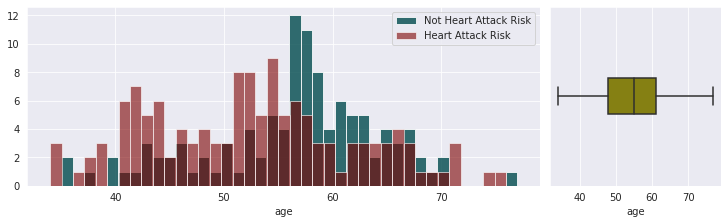

In [31]:
plots("age")

In [32]:
Q1 = train_X["age"].quantile(0.25)
Q3 = train_X["age"].quantile(0.75)
q95th = train_X["age"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["age"] = np.where(train_X["age"] > UW,
                                  q95th, train_X["age"])

# Feature : Sex

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


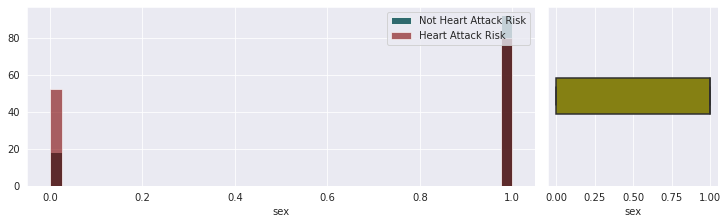

In [33]:
plots("sex")

In [34]:
med = train_X["age"].median()
train_X["age"] = np.where(train_X["age"] == 0, med, train_X["age"])

# Feature : CP

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


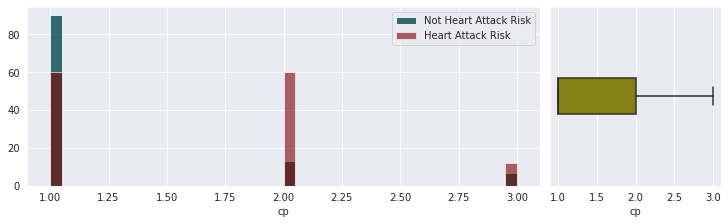

In [35]:
plots("cp")

In [36]:
med = train_X["cp"].median()
q5th = train_X["cp"].quantile(0.05)
q95th = train_X["cp"].quantile(0.95)
Q1 = train_X["cp"].quantile(0.25)
Q3 = train_X["cp"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["cp"] = np.where(train_X["cp"] == 0,
                                    med, train_X["cp"])
train_X["cp"] = np.where(train_X["cp"] < LW,
                                    q5th, train_X["cp"])
train_X["cp"] = np.where(train_X["cp"] > UW,
                                    q95th, train_X["cp"])

# Feature : Trtbps

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


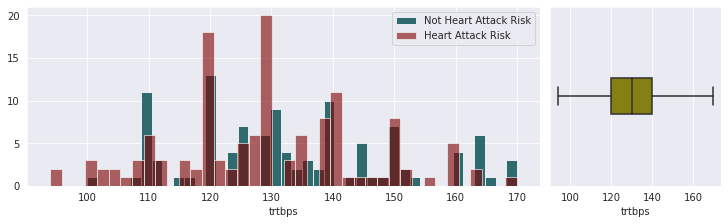

In [37]:
plots("trtbps")

In [39]:
med = train_X["trtbps"].median()
q95th = train_X["trtbps"].quantile(0.95)
Q1 = train_X["trtbps"].quantile(0.25)
Q3 = train_X["trtbps"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["trtbps"] = np.where(train_X["trtbps"] == 0,
                                    med, train_X["trtbps"])
train_X["trtbps"] = np.where(train_X["trtbps"] > UW,
                                    q95th, train_X["trtbps"])

# Feature : chol

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


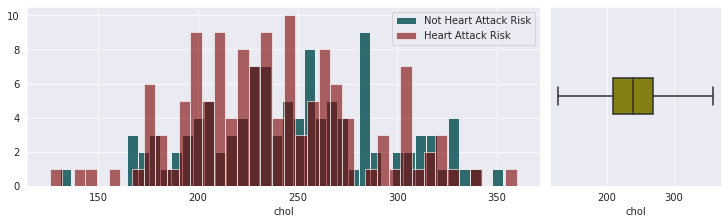

In [40]:
plots("chol")

In [41]:
q60th = train_X["chol"].quantile(0.60)
q95th = train_X["chol"].quantile(0.95)
Q1 = train_X["chol"].quantile(0.25)
Q3 = train_X["chol"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["chol"] = np.where(train_X["chol"] == 0,
                              q60th, train_X["chol"])
train_X["chol"] = np.where(train_X["chol"] > UW,
                              q95th, train_X["chol"])

# Feature : Fbs

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


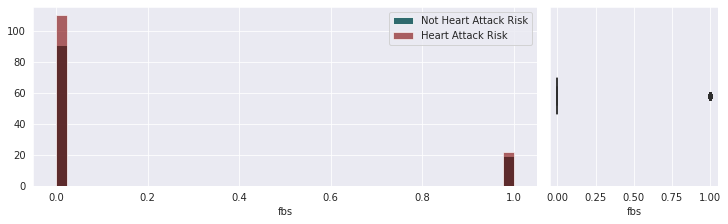

In [42]:
plots("fbs")

In [43]:
q60th = train_X["fbs"].quantile(0.60)
q95th = train_X["fbs"].quantile(0.95)
Q1 = train_X["fbs"].quantile(0.25)
Q3 = train_X["fbs"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["fbs"] = np.where(train_X["fbs"] == 0,
                              q60th, train_X["fbs"])
train_X["fbs"] = np.where(train_X["fbs"] > UW,
                              q95th, train_X["fbs"])

# Feature : restecg

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


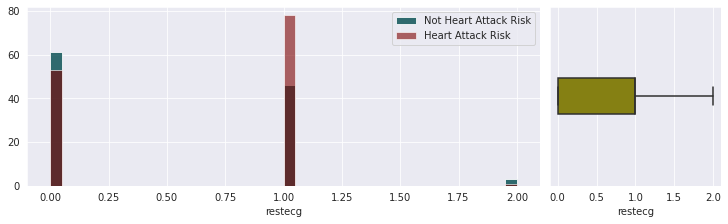

In [44]:
plots("restecg")

In [45]:
q95th = train_X["restecg"].quantile(0.95)
Q1 = train_X["restecg"].quantile(0.25)
Q3 = train_X["restecg"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["restecg"] = np.where(
                        train_X["restecg"] > UW,
                        q95th, train_X["restecg"])

# Feature : oldpeak

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


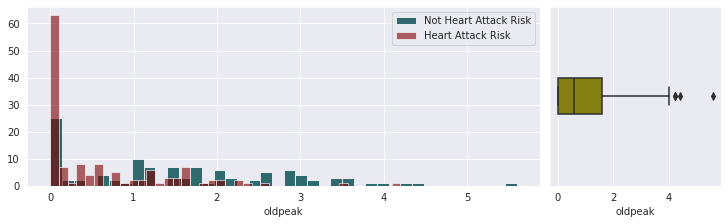

In [46]:
plots("oldpeak")

In [47]:
q95th = train_X["oldpeak"].quantile(0.95)
Q1 = train_X["oldpeak"].quantile(0.25)
Q3 = train_X["oldpeak"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["oldpeak"] = np.where(
                        train_X["oldpeak"] > UW,
                        q95th, train_X["oldpeak"])

# Standarization

In [48]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

# Correlation Analysis

<ipython-input-49-f19a24d61cbe>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


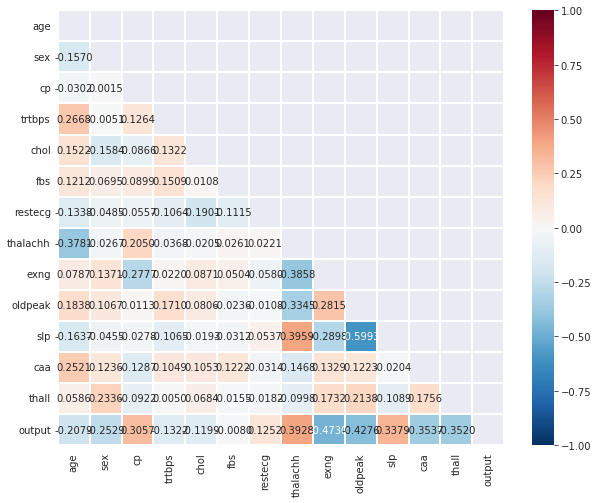

In [49]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

# Feature Importance

In [50]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[-0.07437689, -0.59938553,  0.71063912, -0.28745527, -0.17796018,
         0.07822569,  0.31406701,  0.40634309, -0.69982343, -0.68889394,
         0.24728626, -0.68630669, -0.5880594 ]])

In [51]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[-0.10066936, -0.64568279,  0.73399772, -0.3166458 , -0.21313521,
         0.12211839,  0.33678704,  0.42059082, -0.71673701, -0.68599963,
         0.28341102, -0.71105314, -0.60386081]])

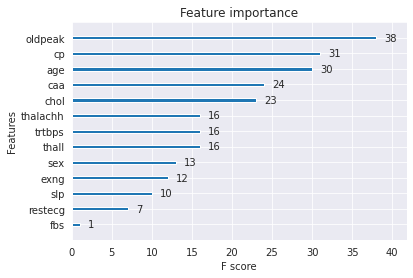

In [52]:
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [54]:
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())


RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=5000,
                                 random_state=0, solver='saga'),
    n_features_to_select=7)

# Train Model

In [55]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

# Test Model

In [57]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Heart Attack Risk",
                                          "Heart Attack Risk"]))

                       precision    recall  f1-score   support

Not Heart Attack Risk     0.7273    0.8571    0.7869        28
    Heart Attack Risk     0.8571    0.7273    0.7869        33

             accuracy                         0.7869        61
            macro avg     0.7922    0.7922    0.7869        61
         weighted avg     0.7975    0.7869    0.7869        61

